# t-SNE

library

In [1]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# list of stopwords like articles, preposition
from string import punctuation
from collections import Counter
import re
stop = set(stopwords.words('english'))

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

data

In [2]:
# data load
data = pd.read_csv('./dataset/uci_news_aggregator.csv', delimiter = ',', skiprows = 1,
                   names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY',
                            'HOSTNAME', 'TIMESTAMP'], usecols=['TITLE', 'CATEGORY'])

In [3]:
data.shape

(422419, 2)

In [4]:
data.head(10)

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
5,Plosser: Fed May Have to Accelerate Tapering Pace,b
6,Fed's Plosser: Taper pace may be too slow,b
7,Fed's Plosser expects US unemployment to fall ...,b
8,US jobs growth last month hit by weather:Fed P...,b
9,ECB unlikely to end sterilisation of SMP purch...,b


In [5]:
# remove rows with empty Titles
data = data[~data['TITLE'].isnull()]

In [6]:
data['len'] = data['TITLE'].map(len)

In [7]:
data.head(10)

,TITLE,CATEGORY,len
0,"Fed official says weak data caused by weather,...",b,68
1,Fed's Charles Plosser sees high bar for change...,b,66
2,US open: Stocks fall after Fed official hints ...,b,69
3,"Fed risks falling 'behind the curve', Charles ...",b,58
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b,50
5,Plosser: Fed May Have to Accelerate Tapering Pace,b,49
6,Fed's Plosser: Taper pace may be too slow,b,41
7,Fed's Plosser expects US unemployment to fall ...,b,72
8,US jobs growth last month hit by weather:Fed P...,b,70
9,ECB unlikely to end sterilisation of SMP purch...,b,60


# Character Level

In [8]:
char_data = data

In [9]:
char_split_num = 10000

In [10]:
from nltk.tokenize import word_tokenize, sent_tokenize
def char_tokenizer(text):
    tokens_ = [text[i] for i in range(len(text))]

#     print(tokens_)
    
    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent

    tokens = list(filter(lambda t: t not in punctuation, tokens))
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

    return filtered_tokens

In [11]:
char_data['tokens'] = data['TITLE'].map(char_tokenizer)

In [12]:
char_data['tokens'][:10]

0    [f, e, d, o, f, f, i, c, i, a, l, s, a, y, s, ...
1    [f, e, d, s, c, h, a, r, l, e, s, p, l, o, s, ...
2    [u, s, o, p, e, n, s, t, o, c, k, s, f, a, l, ...
3    [f, e, d, r, i, s, k, s, f, a, l, l, i, n, g, ...
4    [f, e, d, s, p, l, o, s, s, e, r, n, a, s, t, ...
5    [p, l, o, s, s, e, r, f, e, d, m, a, y, h, a, ...
6    [f, e, d, s, p, l, o, s, s, e, r, t, a, p, e, ...
7    [f, e, d, s, p, l, o, s, s, e, r, e, x, p, e, ...
8    [u, s, j, o, b, s, g, r, o, w, t, h, l, a, s, ...
9    [e, c, b, u, n, l, i, k, e, l, y, t, o, e, n, ...
Name: tokens, dtype: object

In [13]:
def keywords(category):
    tokens = char_data[char_data['CATEGORY'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [14]:
# 각 카테고리 별 top 10 빈도수
for category in set(char_data['CATEGORY']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : m
top 10 keywords: [('e', 239498), ('a', 177903), ('s', 167850), ('i', 156526), ('t', 155089), ('o', 151480), ('r', 144558), ('n', 137505), ('l', 97189), ('c', 83754)]
---
category : t
top 10 keywords: [('e', 551875), ('a', 420587), ('o', 413717), ('s', 392577), ('t', 379356), ('i', 334554), ('n', 326138), ('r', 323004), ('l', 240201), ('c', 191043)]
---
category : e
top 10 keywords: [('e', 824761), ('a', 644750), ('s', 530724), ('o', 525257), ('i', 520649), ('t', 517893), ('r', 517079), ('n', 500896), ('l', 324464), ('d', 264372)]
---
category : b
top 10 keywords: [('e', 550839), ('a', 441518), ('s', 429336), ('o', 383054), ('t', 375203), ('r', 366031), ('i', 365516), ('n', 350144), ('l', 243845), ('c', 188572)]
---


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

char_vectorizer = TfidfVectorizer(min_df=10, max_features=300, tokenizer=char_tokenizer, ngram_range=(1, 2))
vz_char = char_vectorizer.fit_transform(list(char_data['TITLE']))

In [16]:
char_tfidf = dict(zip(char_vectorizer.get_feature_names(), char_vectorizer.idf_))
char_tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(char_tfidf), orient='index')
char_tfidf.columns = ['tfidf']

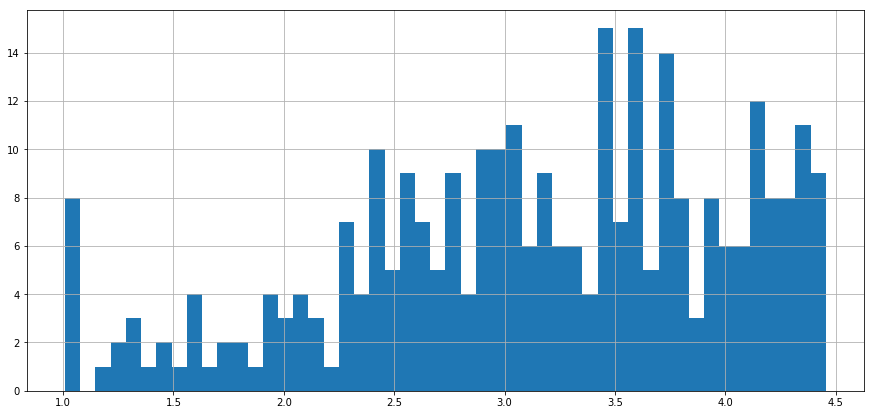

In [17]:
char_tfidf.tfidf.hist(bins=50, figsize=(15,7))

In [18]:
char_tfidf.sort_values(by=['tfidf'], ascending=True).head(30)

,tfidf
e,1.008781
a,1.021771
s,1.030197
o,1.036592
r,1.042377
t,1.043408
i,1.044419
n,1.051729
l,1.157829
c,1.222280


In [19]:
char_tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

,tfidf
u g,4.455983
o e,4.452538
w n,4.440647
m m,4.434241
p u,4.431601
g g,4.415839
u a,4.415767
s k,4.409804
y i,4.398266
j a,4.386160


In [20]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
char_svd_tfidf = svd.fit_transform(vz_char)

In [21]:
from sklearn.manifold import TSNE

char_tsne_model = TSNE(n_components=2, verbose=1, random_state=0, perplexity=50, n_iter=2000)
char_tsne_tfidf = char_tsne_model.fit_transform(char_svd_tfidf[:char_split_num])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 9.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.185748
[t-SNE] KL divergence after 50 iterations with early exaggeration: 90.862213
[t-SNE] Error after 2000 iterations: 2.545509


In [22]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [23]:
char_tfidf_df = pd.DataFrame(char_tsne_tfidf[:char_split_num], columns=['x', 'y'])
char_tfidf_df['title'] = char_data['TITLE']
char_tfidf_df['category'] = char_data['CATEGORY']

In [24]:
char_tfidf_df[:10]

,x,y,title,category
0,-29.917675,1.571768,"Fed official says weak data caused by weather,...",b
1,-21.406853,29.774597,Fed's Charles Plosser sees high bar for change...,b
2,-37.341511,68.815399,US open: Stocks fall after Fed official hints ...,b
3,-7.888693,19.651440,"Fed risks falling 'behind the curve', Charles ...",b
4,-6.257591,6.740469,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
5,-71.732376,-3.893412,Plosser: Fed May Have to Accelerate Tapering Pace,b
6,-71.575859,-3.530813,Fed's Plosser: Taper pace may be too slow,b
7,-42.090546,-33.493313,Fed's Plosser expects US unemployment to fall ...,b
8,-6.233602,6.696592,US jobs growth last month hit by weather:Fed P...,b
9,9.082911,-1.557162,ECB unlikely to end sterilisation of SMP purch...,b


In [25]:
plot_tfidf.scatter(x='x', y='y', source=char_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"title": "@title", "category":"@category"}
show(plot_tfidf)

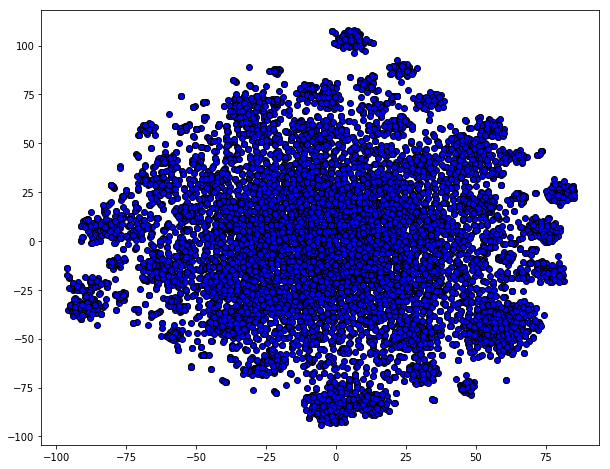

In [26]:
# 크기를 키움
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = char_tfidf_df['x'][:char_split_num]
ys = char_tfidf_df['y'][:char_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
plt.scatter(xs,ys,edgecolor='black',facecolor='blue')
# plt.axis('off')
# plt.colorbar()
plt.show()

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

num_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans_char = kmeans_model.fit(vz_char)
kmeans_clusters_char = kmeans_char.predict(vz_char)
kmeans_distances_char = kmeans_char.transform(vz_char)

In [28]:
for (i, desc),category in zip(enumerate(char_data.TITLE),char_data['CATEGORY']):
    if(i < 5):
        print("Cluster " + str(kmeans_clusters_char[i]) + ": " + desc + 
              "(distance: " + str(kmeans_distances_char[i][kmeans_clusters_char[i]]) + ")")
        print('category: ',category)
        print('---')

Cluster 3: Fed official says weak data caused by weather, should not slow taper(distance: 0.7743696471719606)
category:  b
---
Cluster 9: Fed's Charles Plosser sees high bar for change in pace of tapering(distance: 0.7480266387951411)
category:  b
---
Cluster 2: US open: Stocks fall after Fed official hints at accelerated tapering(distance: 0.7284308221975397)
category:  b
---
Cluster 9: Fed risks falling 'behind the curve', Charles Plosser says(distance: 0.7521175354921156)
category:  b
---
Cluster 6: Fed's Plosser: Nasty Weather Has Curbed Job Growth(distance: 0.796635225939486)
category:  b
---


In [29]:
sorted_centroids = kmeans_char.cluster_centers_.argsort()[:, ::-1]
terms = char_vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Cluster 0:
a | i | e | s | h | n | t | r | o | k | 

Cluster 1:
l | a | e | s | o | i | r | t | n | l l | 

Cluster 2:
t | e | a | r | s | o | n | i | c | t e | 

Cluster 3:
e | a | r | d | n | s | i | t | o | c | 

Cluster 4:
o | e | s | t | r | a | n | i | f | l | 

Cluster 5:
p | e | a | o | s | t | i | r | p p | n | 

Cluster 6:
e | t | h | o | a | t h | r | s | n | h e | 

Cluster 7:
e | i | r | o | s | v | a | n | t | l | 

Cluster 8:
n | i | a | e | o | s | t | i n | r | l | 

Cluster 9:
s | e | a | r | i | o | t | n | e s | s s | 



In [30]:
tsne_kmeans_char = char_tsne_model.fit_transform(kmeans_distances_char[:char_split_num])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 1.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.026152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.169792
[t-SNE] Error after 2000 iterations: 2.171182


In [31]:
import numpy as np

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8"])

In [32]:
kmeans_df_char = pd.DataFrame(tsne_kmeans_char, columns=['x', 'y'])
kmeans_df_char['cluster'] = kmeans_clusters_char[:char_split_num]
kmeans_df_char['title'] = char_data['TITLE']
kmeans_df_char['category'] = char_data['CATEGORY']

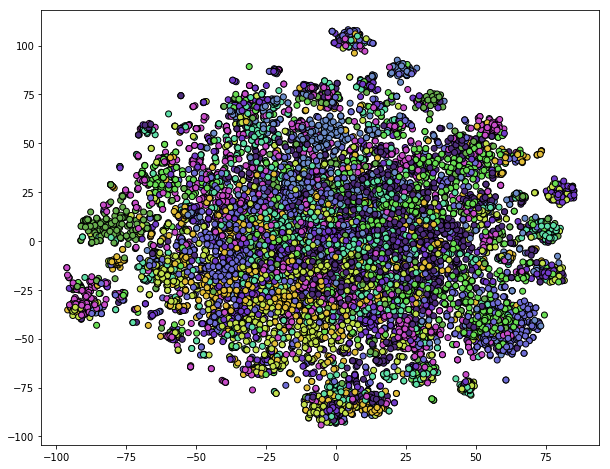

In [33]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = char_tfidf_df['x'][:char_split_num]
ys = char_tfidf_df['y'][:char_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
# plt.scatter(xs,ys,edgecolor='black',facecolor='blue')
plt.scatter(xs,ys,edgecolor='black',facecolor='black',c=colormap[kmeans_clusters_char])
# plt.axis('off')
# plt.colorbar()
plt.show()

In [34]:
char_category_num_list = []
for i in range(char_split_num):
    category = kmeans_df_char['category'][i]
    if category == 'b':
        char_category_num_list.append(0)
    elif category == 't':
        char_category_num_list.append(1)
    elif category == 'e':
        char_category_num_list.append(2)
    elif category == 'm':
        char_category_num_list.append(3)

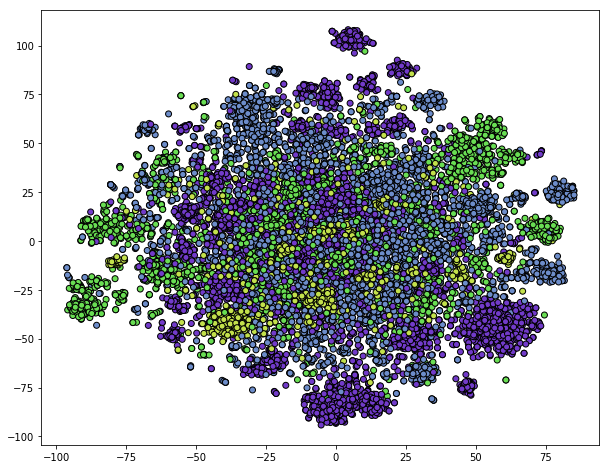

In [35]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = char_tfidf_df['x'][:char_split_num]
ys = char_tfidf_df['y'][:char_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
# plt.scatter(xs,ys,edgecolor='black',facecolor='blue')
plt.scatter(xs,ys,edgecolor='black',facecolor='black',c=colormap[char_category_num_list])
# plt.axis('off')
# plt.colorbar()
plt.show()

# Word Level

In [36]:
word_data = data

In [37]:
word_split_num = 10000

In [38]:
from nltk.tokenize import word_tokenize, sent_tokenize
def word_tokenizer(text):
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]

    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent

    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                        u'\u2014', u'\u2026', u'\u2013'], tokens))
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

    return filtered_tokens

In [39]:
word_data['tokens'] = word_data['TITLE'].map(word_tokenizer)

In [40]:
word_data['tokens'][:10]

0    [fed, official, says, weak, data, caused, weat...
1    [fed, charles, plosser, sees, high, bar, chang...
2    [us, open, stocks, fall, fed, official, hints,...
3    [fed, risks, falling, 'behind, curve, charles,...
4    [fed, plosser, nasty, weather, curbed, job, gr...
5      [plosser, fed, may, accelerate, tapering, pace]
6               [fed, plosser, taper, pace, may, slow]
7    [fed, plosser, expects, us, unemployment, fall...
8    [us, jobs, growth, last, month, hit, weather, ...
9    [ecb, unlikely, end, sterilisation, smp, purch...
Name: tokens, dtype: object

In [41]:
def keywords(category):
    tokens = word_data[word_data['CATEGORY'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [42]:
for category in set(word_data['CATEGORY']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : m
top 10 keywords: [('ebola', 3664), ('study', 3391), ('health', 2733), ('cancer', 2685), ('new', 2549), ('may', 2065), ('virus', 1963), ('us', 1904), ('mers', 1899), ('risk', 1668)]
---
category : t
top 10 keywords: [('google', 11247), ('apple', 9226), ('new', 7948), ('samsung', 7670), ('microsoft', 6410), ('facebook', 5887), ('galaxy', 5834), ('android', 4055), ('one', 3906), ('us', 3027)]
---
category : e
top 10 keywords: [('new', 9066), ('video', 6263), ('kardashian', 5888), ('kim', 5789), ('season', 5319), ("'the", 4919), ('movie', 4429), ('star', 4278), ('review', 4129), ('thrones', 3905)]
---
category : b
top 10 keywords: [('us', 9966), ('new', 4575), ('stocks', 4454), ('china', 4120), ('sales', 3254), ('says', 3178), ('billion', 3015), ('deal', 2936), ('bank', 2926), ('data', 2832)]
---


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

word_vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=word_tokenizer, ngram_range=(1, 2))
vz_word = word_vectorizer.fit_transform(list(word_data['TITLE']))

In [44]:
word_tfidf = dict(zip(word_vectorizer.get_feature_names(), word_vectorizer.idf_))
word_tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(word_tfidf), orient='index')
word_tfidf.columns = ['tfidf']

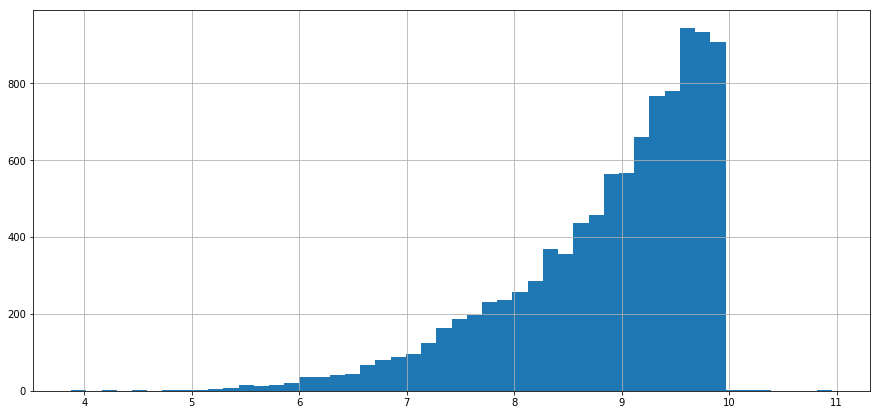

In [45]:
word_tfidf.tfidf.hist(bins=50, figsize=(15,7))

In [46]:
word_tfidf.sort_values(by=['tfidf'], ascending=True).head(30)

,tfidf
new,3.878165
us,4.227184
google,4.573166
apple,4.748428
video,4.817277
says,4.847332
samsung,4.978125
first,4.988038
may,5.005949
microsoft,5.119564


In [47]:
word_tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

,tfidf
http,10.958023
dior,10.290194
vortex,10.125114
funeral procession,10.041732
geldof dead,10.041732
ounce,10.041732
final trailer,9.964771
wet,9.946422
shorts,9.946422
sils,9.946422


In [48]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
word_svd_tfidf = svd.fit_transform(vz_word)

In [49]:
from sklearn.manifold import TSNE

word_tsne_model = TSNE(n_components=2, verbose=1, random_state=0, perplexity=50, n_iter=2000)
word_tsne_tfidf = word_tsne_model.fit_transform(word_svd_tfidf[:word_split_num])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 7.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.018388
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.954109
[t-SNE] Error after 2000 iterations: 0.700448


In [50]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [51]:
word_tfidf_df = pd.DataFrame(word_tsne_tfidf[:word_split_num], columns=['x', 'y'])
word_tfidf_df['title'] = word_data['TITLE']
word_tfidf_df['category'] = word_data['CATEGORY']

In [52]:
plot_tfidf.scatter(x='x', y='y', source=word_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"title": "@title", "category":"@category"}
show(plot_tfidf)

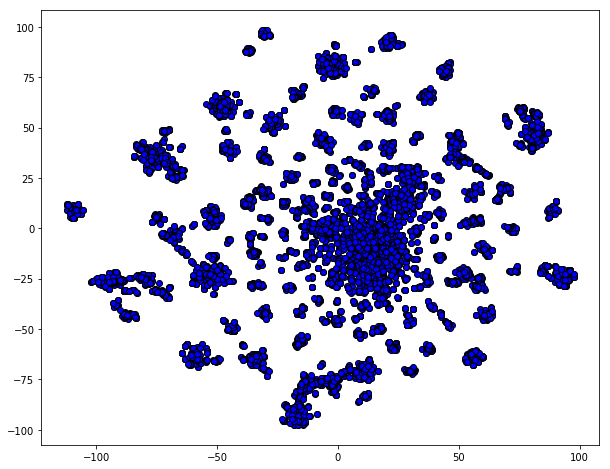

In [53]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = word_tfidf_df['x'][:word_split_num]
ys = word_tfidf_df['y'][:word_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
plt.scatter(xs,ys,edgecolor='black',facecolor='blue')
# plt.axis('off')
# plt.colorbar()
plt.show()

In [54]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

num_clusters = 30
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans_word = kmeans_model.fit(vz_word)
kmeans_clusters_word = kmeans_word.predict(vz_word)
kmeans_distances_word = kmeans_word.transform(vz_word)

In [55]:
for (i, desc),category in zip(enumerate(word_data.TITLE),word_data['CATEGORY']):
    if(i < 5):
        print("Cluster " + str(kmeans_clusters_word[i]) + ": " + desc + 
              "(distance: " + str(kmeans_distances_word[i][kmeans_clusters_word[i]]) + ")")
        print('category: ',category)
        print('---')

Cluster 1: Fed official says weak data caused by weather, should not slow taper(distance: 0.9972955159122309)
category:  b
---
Cluster 1: Fed's Charles Plosser sees high bar for change in pace of tapering(distance: 0.9987774455703499)
category:  b
---
Cluster 21: US open: Stocks fall after Fed official hints at accelerated tapering(distance: 0.9706231717257763)
category:  b
---
Cluster 1: Fed risks falling 'behind the curve', Charles Plosser says(distance: 0.9984017926932149)
category:  b
---
Cluster 1: Fed's Plosser: Nasty Weather Has Curbed Job Growth(distance: 0.9991495762780148)
category:  b
---


In [56]:
sorted_centroids = kmeans_word.cluster_centers_.argsort()[:, ::-1]
terms = word_vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Cluster 0:
miley | cyrus | miley cyrus | stars | tour | dancing stars | bangerz | 'dancing stars | 'dancing | dancing | 

Cluster 1:
new | video | facebook | microsoft | says | first | review | china | one | twitter | 

Cluster 2:
apple | iphone | beats | samsung | ipad | ibm | patent | new | google | ios | 

Cluster 3:
jurassic world | jurassic | sequels | planned | already | world | first | photos | colin | images | 

Cluster 4:
tour due | cyrus postpones | due illness | allergic reaction | postpones | allergic | entire | reaction | illness | due | 

Cluster 5:
study | study finds | finds | study says | new study | says | study shows | facebook | risk | heart | 

Cluster 6:
report | climate | climate change | change | un | says | report says | ipcc | climate report | new | 

Cluster 7:
kim | kardashian | kim kardashian | kanye | kanye west | west | wedding | kardashian kanye | kim kanye | vogue | 

Cluster 8:
shades grey | grey | shades | opens | news | fifty shades | 'fifty shades |

In [57]:
tsne_kmeans_word = word_tsne_model.fit_transform(kmeans_distances_word[:word_split_num])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.033s...
[t-SNE] Computed neighbors for 10000 samples in 4.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.001354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.616760
[t-SNE] Error after 2000 iterations: 0.862021


In [58]:
import numpy as np

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

In [59]:
kmeans_df_word = pd.DataFrame(tsne_kmeans_word, columns=['x', 'y'])
kmeans_df_word['cluster'] = kmeans_clusters_word[:word_split_num]
kmeans_df_word['title'] = word_data['TITLE']
kmeans_df_word['category'] = word_data['CATEGORY']

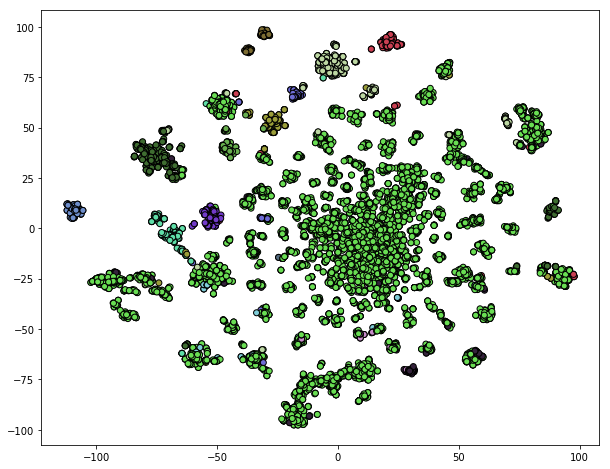

In [60]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = word_tfidf_df['x'][:word_split_num]
ys = word_tfidf_df['y'][:word_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
plt.scatter(xs,ys,edgecolor='black',facecolor='black',c=colormap[kmeans_clusters_word])
# plt.axis('off')
# plt.colorbar()
plt.show()

In [61]:
word_category_num_list = []
for i in range(word_split_num):
    category = kmeans_df_word['category'][i]
    if category == 'b':
        word_category_num_list.append(0)
    elif category == 't':
        word_category_num_list.append(1)
    elif category == 'e':
        word_category_num_list.append(2)
    elif category == 'm':
        word_category_num_list.append(3)

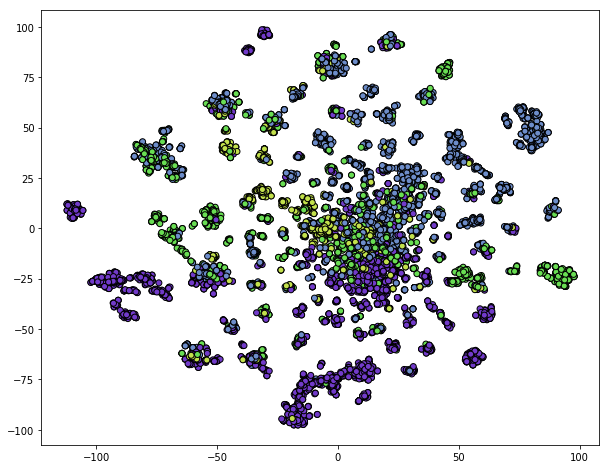

In [62]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
xs = word_tfidf_df['x'][:word_split_num]
ys = word_tfidf_df['y'][:word_split_num]
# ax.set_xticks([])
# ax.set_yticks([])
# plt.scatter(xs,ys,edgecolor='black',facecolor='blue')
plt.scatter(xs,ys,edgecolor='black',facecolor='black',c=colormap[word_category_num_list])
# plt.axis('off')
# plt.colorbar()
plt.show()

compare char_level with word_level

In [63]:
kmeans_df_char[:10]

,x,y,cluster,title,category
0,13.249499,-43.123421,3,"Fed official says weak data caused by weather,...",b
1,58.010170,-45.214752,9,Fed's Charles Plosser sees high bar for change...,b
2,66.399071,-51.234402,2,US open: Stocks fall after Fed official hints ...,b
3,47.875679,-14.115100,9,"Fed risks falling 'behind the curve', Charles ...",b
4,-27.494993,4.489104,6,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
5,-12.872600,-31.540255,5,Plosser: Fed May Have to Accelerate Tapering Pace,b
6,-54.102009,-7.572361,5,Fed's Plosser: Taper pace may be too slow,b
7,-25.902546,-20.115385,4,Fed's Plosser expects US unemployment to fall ...,b
8,56.613708,-70.271111,6,US jobs growth last month hit by weather:Fed P...,b
9,67.112564,-49.922092,9,ECB unlikely to end sterilisation of SMP purch...,b


In [64]:
kmeans_df_word[:10]

,x,y,cluster,title,category
0,26.798231,-59.424519,1,"Fed official says weak data caused by weather,...",b
1,-26.689617,-46.955151,1,Fed's Charles Plosser sees high bar for change...,b
2,20.053411,72.619865,21,US open: Stocks fall after Fed official hints ...,b
3,29.655342,-60.084316,1,"Fed risks falling 'behind the curve', Charles ...",b
4,-46.345013,32.553734,1,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
5,-13.413122,-62.184570,17,Plosser: Fed May Have to Accelerate Tapering Pace,b
6,-13.761440,-61.820992,17,Fed's Plosser: Taper pace may be too slow,b
7,22.632175,72.723885,21,Fed's Plosser expects US unemployment to fall ...,b
8,39.033134,-59.577637,21,US jobs growth last month hit by weather:Fed P...,b
9,-15.449837,9.346212,1,ECB unlikely to end sterilisation of SMP purch...,b
